In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from itertools import product
import pymc3 as pm
import arviz as az

<AxesSubplot:ylabel='Density'>

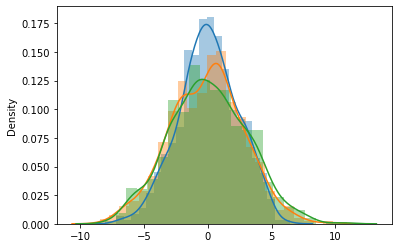

In [2]:
# we have a 1000 people each flipping a coin 16x. They can move 1m left of 1m right depending on the outcome of the flip. They are all lined on a football line. Where will they end up?
n = 1000
steps = 16
flips = [np.sum(np.random.uniform(low=-1,high=1,size=steps)) for i in range(n)]
sns.distplot(flips)

n = 1000
steps = 24
flips = [np.sum(np.random.uniform(low=-1,high=1,size=steps)) for i in range(n)]
sns.distplot(flips)

n = 1000
steps = 30
flips = [np.sum(np.random.uniform(low=-1,high=1,size=steps)) for i in range(n)]
sns.distplot(flips)


<AxesSubplot:ylabel='Density'>

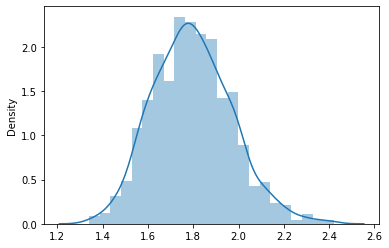

In [3]:
# sample 12 growth rates and multiply them. Becasue the numbers are small their multiplication is close to addition, hence normal distribution
n = 1000
rates = [np.prod(1 + np.random.uniform(low=0,high=0.1,size=12)) for i in range(n)]
sns.distplot(rates)

<AxesSubplot:ylabel='Density'>

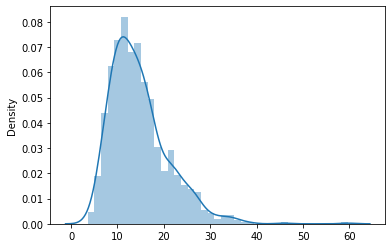

In [4]:
# the numbers being multiplied are getting bigger
n = 1000
rates = [np.prod(1 + np.random.uniform(low=0,high=0.5,size=12)) for i in range(n)]
sns.distplot(rates)

<AxesSubplot:ylabel='Density'>

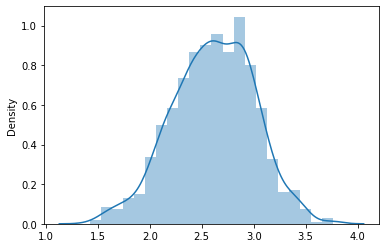

In [5]:
# we can log them to get normal distribution becasue additing logs is like multiplying the original numbers
n = 1000
rates = [np.log(np.prod(1 + np.random.uniform(low=0,high=0.5,size=12))) for i in range(n)]
sns.distplot(rates)

### example of a simple gaussian model 

We model the following model. $h_i$ represents height of ith individual. $\mu$ and $\sigma$ are parameters. The first line is the model, the remaining two lines are priors for the mean and sigma. We take a prior for the mean of 178 and sd of 20 which covers most adults. A prior for sigma must be positive and we select highest value of 50 which will mean 95% ofindividuals will be within 100 of the mean.  


$h_i \sim Normal(\mu, \sigma$)

$\mu \sim Normal(178, 20)$

$\sigma \sim Uniform(0,50)$


Let's plotthe priors

In [6]:
d = pd.read_csv("https://raw.githubusercontent.com/schubertjan/resources/master/Rethinking/Data/Howell1.csv", sep=";")
h = d.loc[d["age"] > 18, "height"].values

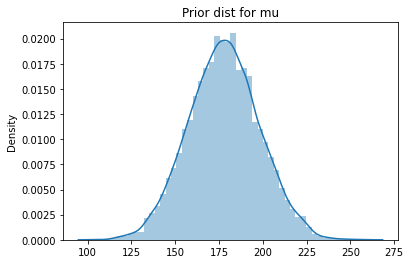

In [7]:
sns.distplot(stats.norm.rvs(178, 20, 10000)).set_title("Prior dist for mu")
plt.show()

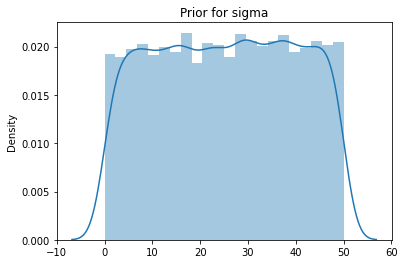

In [8]:
sns.distplot(stats.uniform.rvs(0, 50, 10000)).set_title("Prior for sigma")
plt.show()

Let's do a prior predictive simulation to check if our priors generate a sensible model

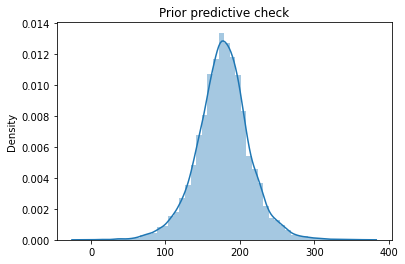

In [9]:
mu_priors = stats.norm.rvs(178, 20, 10000)
sigma_priors = stats.uniform.rvs(0, 50, 10000)
prior_h = stats.norm.rvs(mu_priors, sigma_priors, 10000)
sns.distplot(prior_h).set_title("Prior predictive check")
plt.show()

No mame hodne vysokych a nizkych lidi, takze nas model by asi mohl mit mensi sigma, ale alespon nemame nikoho, kdo by byl mensi nez 0cm. Muzeme pristoupit k grid_approximation

In [10]:
# create grid for mean and sigma
mu_grid = np.linspace(150, 160, 100)
sigma_grid = np.linspace(7, 9, 100)

# create all possible combinations of posterior true values of mu and sigma 
post = pd.DataFrame(list(product(mu_grid, sigma_grid)), columns = ["mu", "sigma"])
# create columns for storing log likelihoods
post["LL"] = np.NaN

# calculate likelihood for all combinations of mu and sigma
for index, row in post.iterrows():
    # we calculate density of heights for each combination of sigma and sum. We do this on a log scale becasue it is more precise 
    post["LL"][index] = np.sum(stats.norm.logpdf(h, loc=row["mu"],scale=row["sigma"]))

# multiply likelihood by prior prob. We addition because we work with log
post["prob"] = post["LL"] + stats.norm.logpdf(post["mu"], 178, 20) + stats.uniform.logpdf(post["sigma"], 0.01, 50)

# we scale by removing max. This way the pro will be between -inf to 0, hence 0-1 when exp
post["prob"] = np.exp(post["prob"] - post["prob"].max())

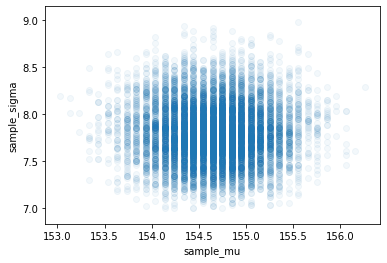

In [11]:
# now we will sample from the posterior
sample_row = np.random.choice(np.arange(0, post.shape[0]), replace=True, p = post["prob"]/post["prob"].sum(), size = 10000)
sample_mu = post["mu"].values[sample_row]
sample_sigma = post["sigma"].values[sample_row]

plt.plot(sample_mu, sample_sigma, "o", alpha=0.05)
plt.axis('equal')
plt.grid(False)
plt.xlabel('sample_mu')
plt.ylabel('sample_sigma')
plt.show()

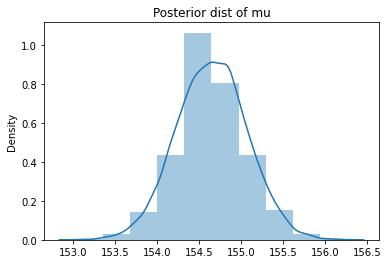

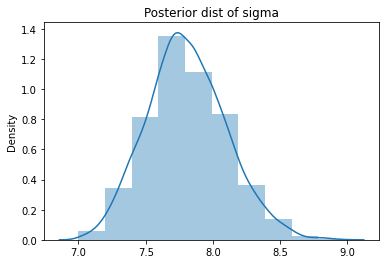

89% PI of posterior dist of mu: [153.93939394 155.35353535]
89% PI of posterior dist of sigma: [7.34343434 8.29292929]


In [12]:
sns.distplot(sample_mu, bins=10).set_title("Posterior dist of mu")
plt.show()
sns.distplot(sample_sigma, bins=10).set_title("Posterior dist of sigma")
plt.show()
print("89% PI of posterior dist of mu: {}".format(np.quantile(sample_mu, q = [0.055, 0.945])))
print("89% PI of posterior dist of sigma: {}".format(np.quantile(sample_sigma, q = [0.055, 0.945])))

What would be the impact of a smaller sample?

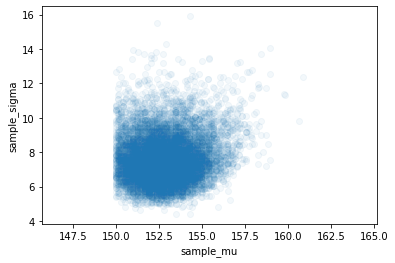

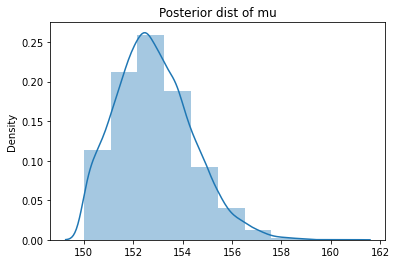

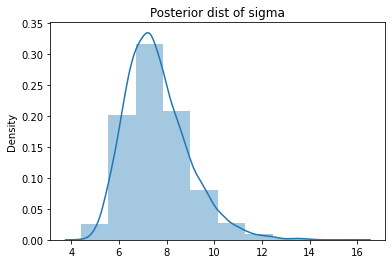

89% PI of posterior dist of mu: [150.50251256 155.42713568]
89% PI of posterior dist of sigma: [5.76884422 9.94974874]


In [13]:
h2 = np.random.choice(h, replace=False, size = 20)

# create grid for mean and sigma
mu_grid = np.linspace(150, 170, 200)
sigma_grid = np.linspace(4, 20, 200)

# create all possible combinations of posterior true values of mu and sigma 
post = pd.DataFrame(list(product(mu_grid, sigma_grid)), columns = ["mu", "sigma"])
# create columns for storing log likelihoods
post["LL"] = np.NaN

# calculate likelihood for all combinations of mu and sigma
for index, row in post.iterrows():
    # we calculate density of heights for each combination of sigma and sum. We do this on a log scale becasue it is more precise 
    post["LL"][index] = np.sum(stats.norm.logpdf(h2, loc=row["mu"],scale=row["sigma"]))

# multiply likelihood by prior prob. We addition because we work with log
post["prob"] = post["LL"] + stats.norm.logpdf(post["mu"], 178, 20) + stats.uniform.logpdf(post["sigma"], 0.01, 50)

# we scale by removing max. This way the pro will be between -inf to 0, hence 0-1 when exp
post["prob"] = np.exp(post["prob"] - post["prob"].max())

# now we will sample from the posterior
sample_row = np.random.choice(np.arange(0, post.shape[0]), replace=True, p = post["prob"]/post["prob"].sum(), size = 10000)
sample_mu = post["mu"].values[sample_row]
sample_sigma = post["sigma"].values[sample_row]

plt.plot(sample_mu, sample_sigma, "o", alpha=0.05)
plt.axis('equal')
plt.grid(False)
plt.xlabel('sample_mu')
plt.ylabel('sample_sigma')
plt.show()

sns.distplot(sample_mu, bins=10).set_title("Posterior dist of mu")
plt.show()
sns.distplot(sample_sigma, bins=10).set_title("Posterior dist of sigma")
plt.show()
print("89% PI of posterior dist of mu: {}".format(np.quantile(sample_mu, q = [0.055, 0.945])))
print("89% PI of posterior dist of sigma: {}".format(np.quantile(sample_sigma, q = [0.055, 0.945])))

### Using a sample (originally quadratic approximation)

In [14]:
np.random.seed(42)
m4_1 = pm.Model()
# model specification
with m4_1:
    mu = pm.Normal('mu', mu=178, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=h)

In [15]:
with m4_1:
    trace_4_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

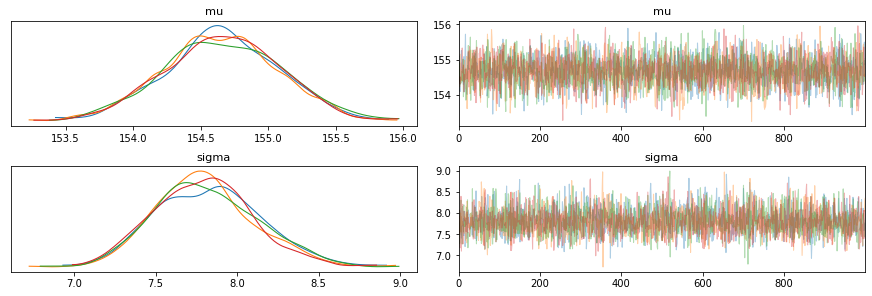

In [16]:
az.plot_trace(trace_4_1)

In [17]:
az.summary(trace_4_1, hdi_prob=.89).round(2)

mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
mu     154.66  0.43    153.99     155.36       0.01      0.0    3222.0   
sigma    7.81  0.31      7.30       8.29       0.00      0.0    3541.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
mu     3222.0    3215.0    2478.0    1.0  
sigma  3516.0    3591.0    2524.0    1.0

## Linear Regression

1. likelihood: $h_i \sim Normal(\mu_i, \sigma)$
2. linear model: $\mu_i = \alpha + \beta(x_i - \overline{x})$
3. alpha prior: $\alpha \sim Normal(178,20)$
4. beta prior: $\beta \sim Normal(0, 10)$
5. sigma prior: $\sigma \sim Uniform(0, 50)$


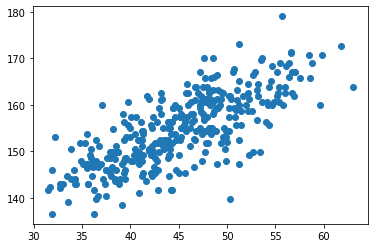

In [18]:
d2 = d.loc[d["age"] > 18, ] 
plt.scatter(d2["weight"], d2["height"])
plt.show()

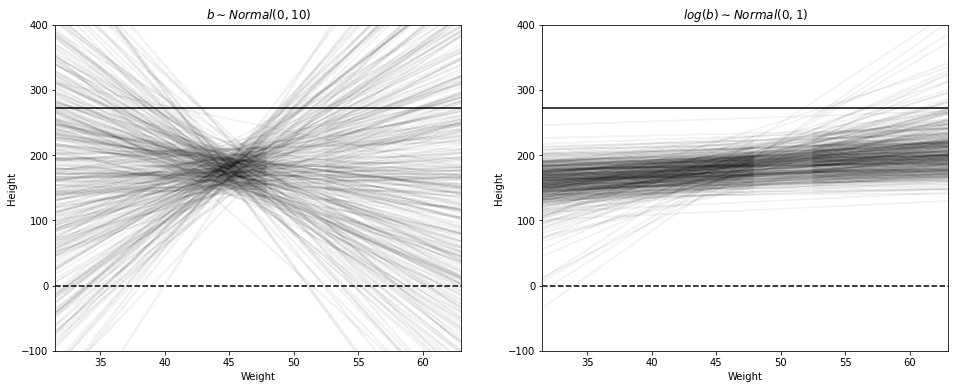

In [19]:
#prior predictive checks
np.random.seed(42)
n = d2.shape[0]
A = stats.norm.rvs(size=n, loc=178, scale=20)
B = stats.norm.rvs(size=n, loc=0, scale=10)

fig, ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].set_xlim((d2["weight"].min(), d2["weight"].max()))
ax[0].set_ylim((-100, 400))
ax[0].set_xlabel("Weight")
ax[0].set_ylabel("Height")
ax[0].set_title("$b \sim Normal(0, 10)$")

x_bar = d2["weight"].mean()
for a,b in zip(A,B):
    x_line = a + b * (d2["weight"] - x_bar)
    ax[0].plot(d2["weight"], x_line, color = "black", alpha = 0.05)

ax[0].hlines(0, xmin = d2["weight"].min(), xmax= d2["weight"].max(), linestyles="--", color = "black")
ax[0].hlines(272, xmin = d2["weight"].min(), xmax= d2["weight"].max(), color = "black")

#lognormal prior for beta
B = stats.lognorm.rvs(s=1, loc=0, scale=np.exp(0), size=n)

ax[1].set_xlim((d2["weight"].min(), d2["weight"].max()))
ax[1].set_ylim((-100, 400))
ax[1].set_xlabel("Weight")
ax[1].set_ylabel("Height")
ax[1].set_title("$log(b) \sim Normal(0, 1)$")

x_bar = d2["weight"].mean()
for a,b in zip(A,B):
    x_line = a + b * (d2["weight"] - x_bar)
    ax[1].plot(d2["weight"], x_line, color = "black", alpha = 0.05)

ax[1].hlines(0, xmin = d2["weight"].min(), xmax= d2["weight"].max(), linestyles="--", color = "black")
ax[1].hlines(272, xmin = d2["weight"].min(), xmax= d2["weight"].max(), color = "black")
plt.show()

#### using log-normal prior for beta is a model that reflects the reality better we generally get lines that are within the smalles and tallest person

1. likelihood: $h_i \sim Normal(\mu_i, \sigma)$
2. linear model: $\mu_i = \alpha + \beta(x_i - \overline{x})$
3. alpha prior: $\alpha \sim Normal(178,20)$
4. beta prior: $\beta \sim Log-Normal(0, 10)$
5. sigma prior: $\sigma \sim Uniform(0, 50)$  

In [20]:
m4_4 = pm.Model()

with m4_4:
    alpha = pm.Normal("alpha", 178, 20)
    beta = pm.Lognormal("beta", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = alpha + beta * (d2["weight"] - x_bar)
    height = pm.Normal("height", mu = mu, sd = sigma, observed=d2.height)
    trace4_4 = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

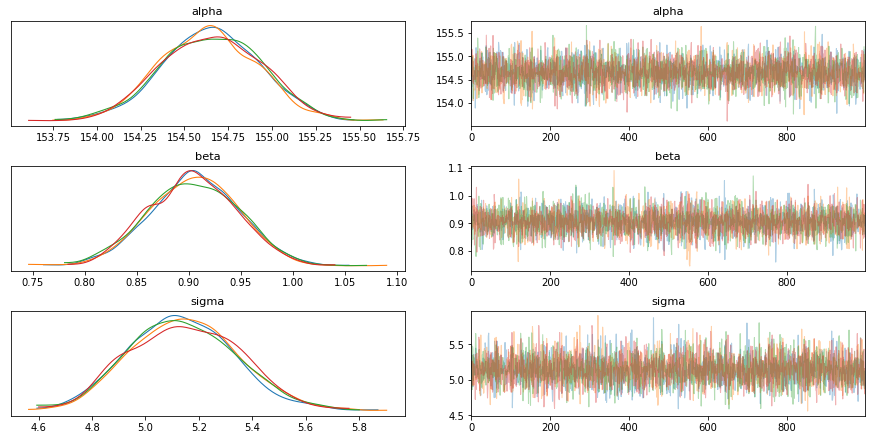

In [21]:
az.plot_trace(trace4_4)

In [22]:
az.summary(trace4_4)

mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha  154.650  0.280  154.150  155.186      0.004    0.003    4868.0  4868.0   
beta     0.905  0.043    0.821    0.981      0.001    0.000    4580.0  4580.0   
sigma    5.143  0.201    4.769    5.509      0.003    0.002    5558.0  5527.0   

       ess_bulk  ess_tail  r_hat  
alpha    4863.0    3322.0    1.0  
beta     4604.0    2537.0    1.0  
sigma    5568.0    3245.0    1.0

In [23]:
N = np.random.randint(low=0, high = len(trace4_4["alpha"]), size = 1000)
mu_pred = pd.DataFrame(index = np.arange(0, d2.shape[0]))

for n in N:
    #sampleform posterior and calculate the predicted mu
    mu_pred_aux = trace4_4["alpha"][n] + trace4_4["beta"][n] * (d2.weight - x_bar)
    # reset index to have the same index
    mu_pred_aux.reset_index(drop=True, inplace=True)
    mu_pred.reset_index(drop=True, inplace=True)
    mu_pred = pd.concat([mu_pred, mu_pred_aux], axis = 1, ignore_index=True)

mu_pred = mu_pred.transpose()

In [24]:
# predict probability of predicted valye of size for each value of height (for each mu and sigma)
height_pred = pm.sample_posterior_predictive(trace4_4, 1000, m4_4)
height_pred_hpd = az.hpd(height_pred["height"])

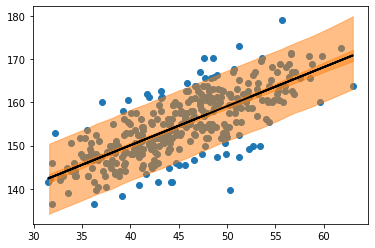

In [25]:
d2 = d.loc[d["age"] > 18, ] 

fig, ax = plt.subplots()
ax.scatter(d2["weight"], d2["height"])
ax.plot(d2["weight"], trace4_4["alpha"].mean() + trace4_4["beta"].mean() * (d2.weight - x_bar), color = "black", linewidth = 2)
az.plot_hpd(d2.weight, mu_pred, credible_interval = 0.89, ax = ax)
az.plot_hpd(d2.weight, height_pred["height"], credible_interval = 0.89, ax = ax)
plt.show()

## Excercise

4M1. Simulate a prior predictive check for the following model

$y_i \sim Normal(\mu, \sigma)$

$\mu \sim Normal(0, 10)$

$\sigma \sim Exponential(1)$

<AxesSubplot:ylabel='Density'>

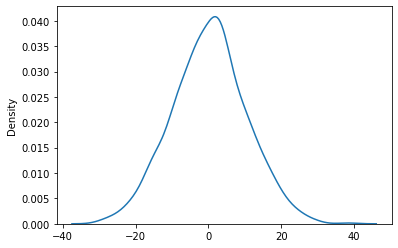

In [26]:
n = 1000
mu_check = stats.norm.rvs(loc=0, scale=10, size=n)
sigma_check = stats.expon.rvs(1, size=n)
y_check = stats.norm.rvs(loc=mu_check, scale=sigma_check)
sns.distplot(y_check, hist=False)

In [27]:
# 4M7 Refit the linear model from this chapter but omit xbar. Compare posterior prediction

m47 = pm.Model()
with m47:
    alpha = pm.Normal("alpha", 178, 20)
    beta = pm.Lognormal("beta", 0, 1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = alpha + beta * d2.weight
    h = pm.Normal("h", mu, sigma, observed=d2.height)
    trace_m47 = pm.sample(1000, tune = 1000)

print(az.summary(trace_m47, credible_interval=0.89))
#check correlation
m47_df = pm.trace_to_dataframe(trace_m47)
print(m47_df.corr())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The acceptance probability does not match the target. It is 0.8960441868081777, but should be close to 0.8. Try to increase the number of tuning steps.
          mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha  114.530  1.921  110.930  118.092      0.053    0.037    1317.0  1315.0   
beta     0.891  0.042    0.815    0.972      0.001    0.001    1287.0  1287.0   
sigma    5.144  0.206    4.764    5.542      0.005    0.003    1987.0  1987.0   

       ess_bulk  ess_tail  r_hat  
alpha    1323.0    1609.0    1.0  
beta     1295.0    1673.0    1.0  
sigma    1971.0    1298.0    1.0  
          alpha      beta     sigma
alpha  1.000000 -0.989676  0.028380
beta  -0.989676  1.000000 -0.026588
sigma  0.028380 -0.026588  1.000000


In [28]:
#predictive interval for each value of weight
height_pred = pm.sample_posterior_predictive(trace_m47, 1000, m47)

az.plot_hpd(d2.weight, height_pred['h'], credible_interval = 0.89)
plt.scatter(d2.weight, d2.height)
plt.plot(d2.weight, trace_m47["alpha"].mean() + trace_m47["beta"].mean() * d2.weight)
plt.show()

In [77]:
#4M8. increase the numer of knots
from patsy import dmatrix
blossoms = pd.read_csv("https://raw.githubusercontent.com/schubertjan/resources/master/Rethinking_2/Data/cherry_blossoms.csv", parse_dates=True)
blossoms = blossoms.dropna(subset=["doy"])

num_knots = 3
knot_list = np.quantile(blossoms.year, np.linspace(0, 1, num_knots))
B = dmatrix(
    "bs(year, knots = knots, degree=3, include_intercept=True) -1 ",
    {"year": blossoms.year.values, "knots": knot_list[1:-1]}
)

In [78]:
m48 = pm.Model()

with m48:
    a = pm.Normal("a", 100, 10)
    w = pm.Normal("w", 0, sd=10, shape=B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    sigma = pm.Exponential("sigma",1)
    D = pm.Normal("D", mu, sigma, observed=blossoms.doy)
    trace48 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, w, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The number of effective samples is smaller than 25% for some parameters.


<AxesSubplot:>

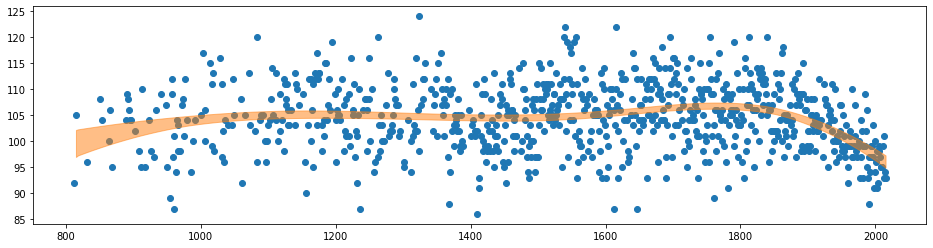

In [79]:
fig, ax = plt.subplots(figsize=(16,4))

ax.scatter(blossoms.year, blossoms.doy)
az.plot_hpd(blossoms.year, trace48["mu"], credible_interval=0.89, ax = ax)